# __Project Description__


Dataset: https://archive.ics.uci.edu/ml/datasets/bank+marketing

The goal of the project is to determine will the client subscribe a bank term deposit

## __Referenced papers__
1. https://ieeexplore.ieee.org/abstract/document/9065648
2. https://www.researchgate.net/publication/323198261_Customer_Profiling_using_Classification_Approach_for_Bank_Telemarketing
3. https://ieeexplore.ieee.org/abstract/document/8391441
4. https://ieeexplore.ieee.org/document/9655824

# __Exploratory Data Analysis__

First we read the dataset into dataframe. Notice that the dataset is a csv file but separated by `;`

In [1]:
import pandas as pd

df = pd.read_csv("./dataset/bank-additional/bank-additional.csv",sep=";")

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Drop column __duration__, according to UCI:    

> ` this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.`

In [2]:
df.drop(columns="duration", inplace=True)


Getting info of dataframe. There is no null data in any of the feature. So we don't need to handle this case

In [3]:
df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  campaign        4119 non-null   int64  
 11  pdays           4119 non-null   int64  
 12  previous        4119 non-null   int64  
 13  poutcome        4119 non-null   object 
 14  emp.var.rate    4119 non-null   float64
 15  cons.price.idx  4119 non-null   float64
 16  cons.conf.idx   4119 non-null   float64
 17  euribor3m       4119 non-null   f

### __Visualization__

Visualizing distribution of categorical features and label using pie chart. As can be seen, we have a fairly imbalanced data


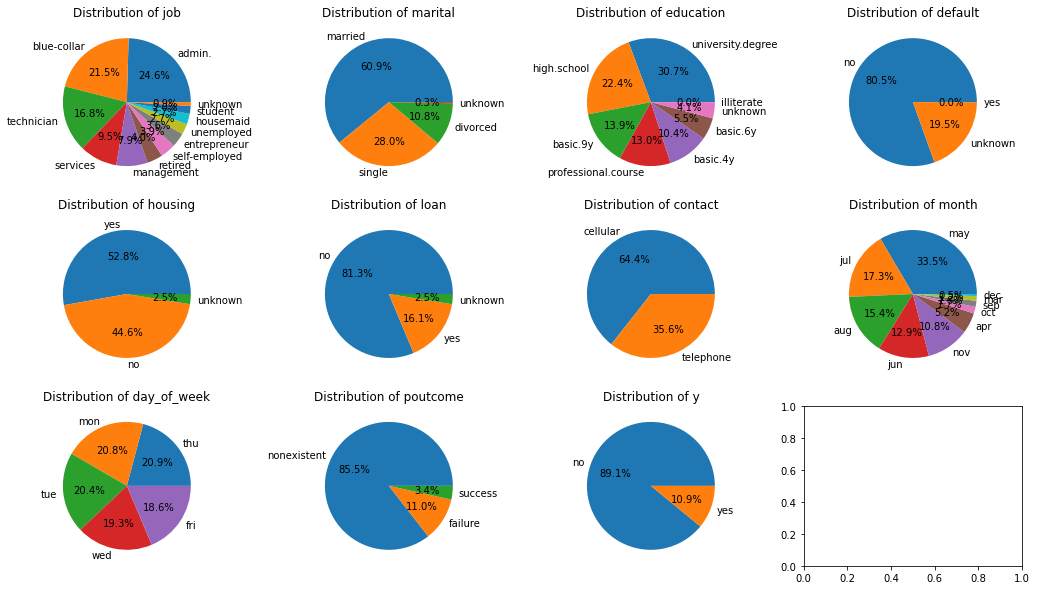

In [4]:
import matplotlib.pyplot as plt

pie_visualization = ["job", "marital", "education",
                     "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome",  "y"]

fig, axes = plt.subplots(3, 4, figsize=(18, 10))

for i, feature in enumerate(pie_visualization):
    category = df[feature].value_counts()
    axes.flat[i].set_title("Distribution of {}".format(feature))
    axes.flat[i].pie(category, labels=category.index, autopct='%1.1f%%')


Visualizing when the data is normally collected. As can be seen, most of the data is collected around May. The day_of_week is fairly balanced

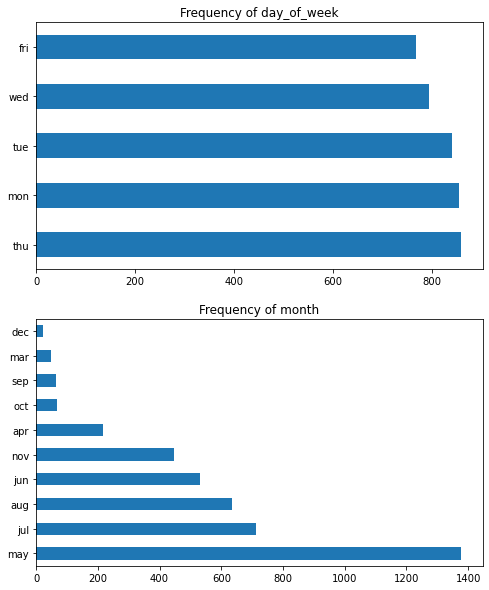

In [5]:
bar_visualization = ["day_of_week", "month"]
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
for i, ax in enumerate(axes.flat, start=0):
    feature = bar_visualization[i]
    df[feature].value_counts().plot(kind="barh", ax=ax,title="Frequency of {}".format(feature))


Visualizing correlation between numeric features    

As can be noticed from the graph, `emp.var.rate`, `nr.employed`, `euribor3m`,`cons.price.index` are highly correlated
Depending on the algorithm, we may need remove one of the above listed features. This is a **Multicollinearity** problem 

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

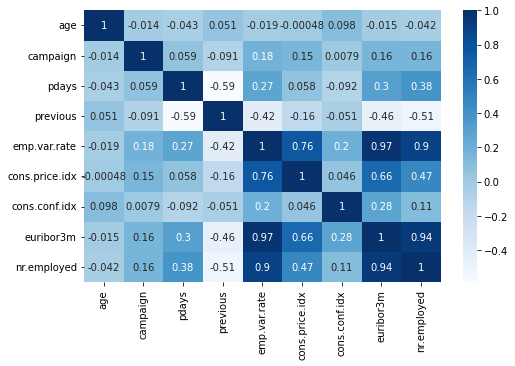

In [6]:
import seaborn as sb
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8, 5
numerical_features = ["age", "campaign", "pdays", "previous", "emp.var.rate",
                      "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

corr = df[numerical_features].corr()
print(type(corr))
sb.heatmap(corr, cmap="Blues", annot=True)


For numerical features, we are also interested in their distributions. 

As can be seen, there are lots of outliers in age, campaign, pdays, previous

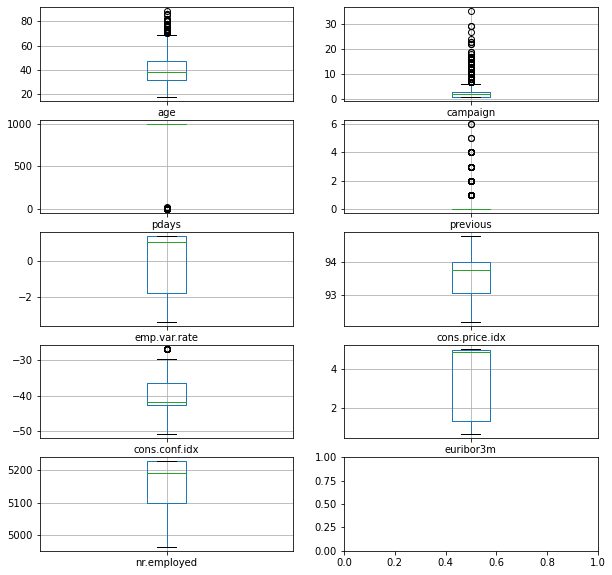

In [7]:
from math import ceil


fig, axes = plt.subplots(ceil(len(numerical_features)/2),2, figsize=(10, 10))

for i, feature in enumerate(numerical_features):
    df.boxplot(column=feature, ax=axes.flat[i])


For features with many outliers, count frequency

We notice that, people between 25 and 60 years old will likely to invest.

For `campaign`, there are many who gets contacted by bank representative by the first time, the same can be said for `pdays` and `previous`.

Potentially, we need to remove outliers from the 4 mentioned features

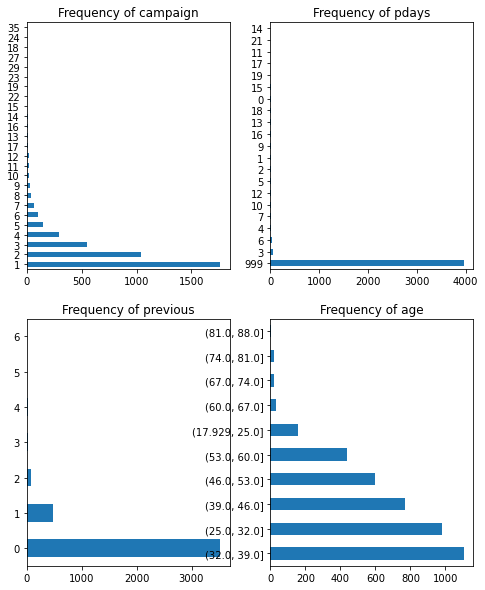

In [8]:
feature_outliers = ["campaign", "pdays", "previous"]
fig, axes = plt.subplots(2, 2, figsize=(8, 10))

df["age"].value_counts(bins=10).plot(kind="barh", title="Frequency of age")

for i, feature in enumerate(feature_outliers):
    df[feature].value_counts().plot(
        kind="barh", ax=axes.flat[i], title="Frequency of {}".format(feature))


### __Prepare data for ML algorithms__

Some ML algorithms do not work well with categorical data, therefore, we need to convert those categorical data to number.

There are several features that are strictly __nominal__, perform **One Hot Encoder** on these features. Some features are __ordinal__, with these features, we perform **Ordinal Encoder**.

In [4]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Ordering array from low to high
# The first element has lowest priority, the last element has highest priority
# This ranking is important!!
education = ["illiterate", "basic.4y", "basic.6y", "basic.9y",
             "unknown", "high.school", "professional.course", "university.degree"]

credit_default = ["yes", "unknown", "no"]

poutcome = ["failure", "nonexistent", "success"]

# 0 means no, 1 means yes
y = ["no", "yes"]

columnTransformer = ColumnTransformer(
    [
        ("OneHotEncoder", OneHotEncoder(), [
         "job", "marital", "contact", "housing", "loan", "day_of_week", "month"]),
        ("OrdinalEncoder", OrdinalEncoder(
            categories=[education, credit_default, poutcome, y]),
            ["education", "default", "poutcome", "y"]),
    ],
    remainder="passthrough"
)

transformed_df = pd.DataFrame(
    columnTransformer.fit_transform(df),
    columns=columnTransformer.get_feature_names_out()
)

# Need to find out a way to feature engineering day and month
# Cannot use label encoding these data are cyclical data in nature
# Refer https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
# Also, should housing and loan be in encoded using OrdinalEncoder or OneHotEncoder?
# I feel like there is no direct ranking between them so to play it safe, I use OneHotEncoder for it

transformed_df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Columns: 52 entries, OneHotEncoder__job_admin. to remainder__nr.employed
dtypes: float64(52)
memory usage: 1.6 MB


After running the encoder, we notice that the `dtypes` of dataframe is `float64` for all features!
Now we separate features and label

In [5]:
x = transformed_df.drop(columns=["OrdinalEncoder__y"])
y = transformed_df["OrdinalEncoder__y"]

print(x.info(verbose=False))
print(y.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Columns: 51 entries, OneHotEncoder__job_admin. to remainder__nr.employed
dtypes: float64(51)
memory usage: 1.6 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 4119 entries, 0 to 4118
dtypes: float64(1)
memory usage: 32.3 KB
None


# Algorithms

## Paper 1
Link: https://ijcsi.org/papers/IJCSI-13-5-69-75.pdf 

The best Algorithm in this Paper in Naive Bayes with an accuracy of 88.4% and misclassification percentage of 11.6



Accuracy: 0.901699
/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


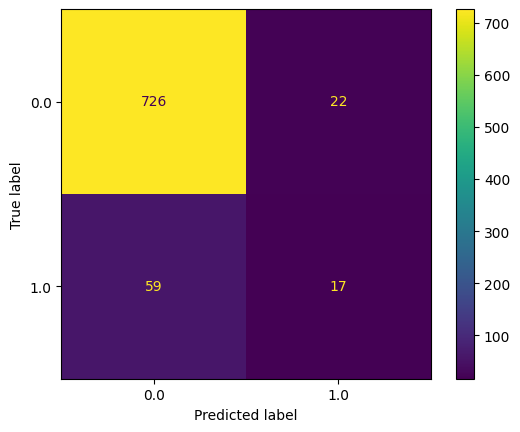

In [6]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA 
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(x)
feature_pca = pca.transform(x)

X_trainP, X_testP, y_trainP, y_testP = train_test_split(feature_pca, y, test_size=0.2, random_state=0)

gnb = GaussianNB()
gnb.fit(X_trainP, y_trainP)

accuracy_PCA = gnb.score(X_testP, y_testP)
print("Accuracy: %f" % accuracy_PCA)

plot_confusion_matrix(gnb, X_testP, y_testP)  
plt.show()


### Results

We had an accuracy score of 90.17%, whereas the research paper accuray score is 88.4%.
We had a misclassification score of 9.83 whereas the research papers is 11.6%.
Clearly our implementation performed better and it can be deduced that it is because we used dimension reduction(PCA) in our implementation. 



## Paper 2

Link: https://www.researchgate.net/publication/323198261_Customer_Profiling_using_Classification_Approach_for_Bank_Telemarketing

Using C4.5 algorithm to predict if a client will subscribe a term deposit.  

In theory, decision tree should be able to work with categorical data. However, the current implementation of   
decision tree in scikit-learn 1.1 does not handle categorical data. Refer https://scikit-learn.org/1.1/modules/tree.html    

As a result, we need to use OneHotEncoder and Ordinal Encoder on the features. `transformed_df` variable is a dataframe that
has all features encoded.

There are trades off of doing this, notably higher tree depth and the time it takes for the algorithm to finish is longer...

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn import tree

%matplotlib inline


def report_result(y_pred, y_true, clf):
    cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    print(classification_report(y_true, y_pred))


def tree_visualizer(tree_classifier, feature_names):
    fig = plt.figure(figsize=(25, 20))
    _ = tree.plot_tree(tree_classifier,
                       feature_names=feature_names,
                       class_names=['No', "Yes"],
                       filled=True)


In [12]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

# The following features are not used by the paper, therefore, we're not going to use these features as well
tree_dataset_x = x.drop(columns=["remainder__euribor3m", "remainder__nr.employed",
                                 "remainder__cons.price.idx", "remainder__emp.var.rate", "remainder__cons.conf.idx"], inplace=False)

# Seperate into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    tree_dataset_x, y, train_size=0.7, test_size=0.3, random_state=0, stratify=y)


Hyper parameter tuning with decision tree using `K Fold Cross Validation` technique implemented in `GridSearchCV`

We do not need to scale data in order to use decision tree, thus it will be skipped.

The scoring criteria here will be `balanced_accuracy`, this is to account for our imbalanced dataset

In [13]:
from sklearn.pipeline import Pipeline

dec_tree = DecisionTreeClassifier(random_state=22)
pipe = Pipeline(steps=[
    ('dec_tree', dec_tree)])

parameters = dict(
    dec_tree__criterion=['gini', 'entropy'],
    dec_tree__max_depth=[2, 4, 6, 8],
    dec_tree__min_samples_leaf=[1,2],
    dec_tree__splitter=["best", "random"],
    dec_tree__max_features=["sqrt", "log2"]
)

tree_tuning = GridSearchCV(
    pipe, parameters, scoring="accuracy", cv=10)

tree_tuning.fit(x_train, y_train)
print("Best params", tree_tuning.best_params_)


Best params {'dec_tree__criterion': 'entropy', 'dec_tree__max_depth': 2, 'dec_tree__max_features': 'log2', 'dec_tree__min_samples_leaf': 1, 'dec_tree__splitter': 'best'}


Report trainning score result

Using tuned parameters on the test dataset

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1101
         1.0       0.64      0.21      0.31       135

    accuracy                           0.90      1236
   macro avg       0.77      0.60      0.63      1236
weighted avg       0.88      0.90      0.88      1236



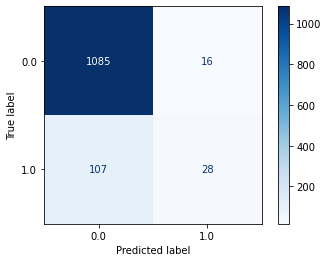

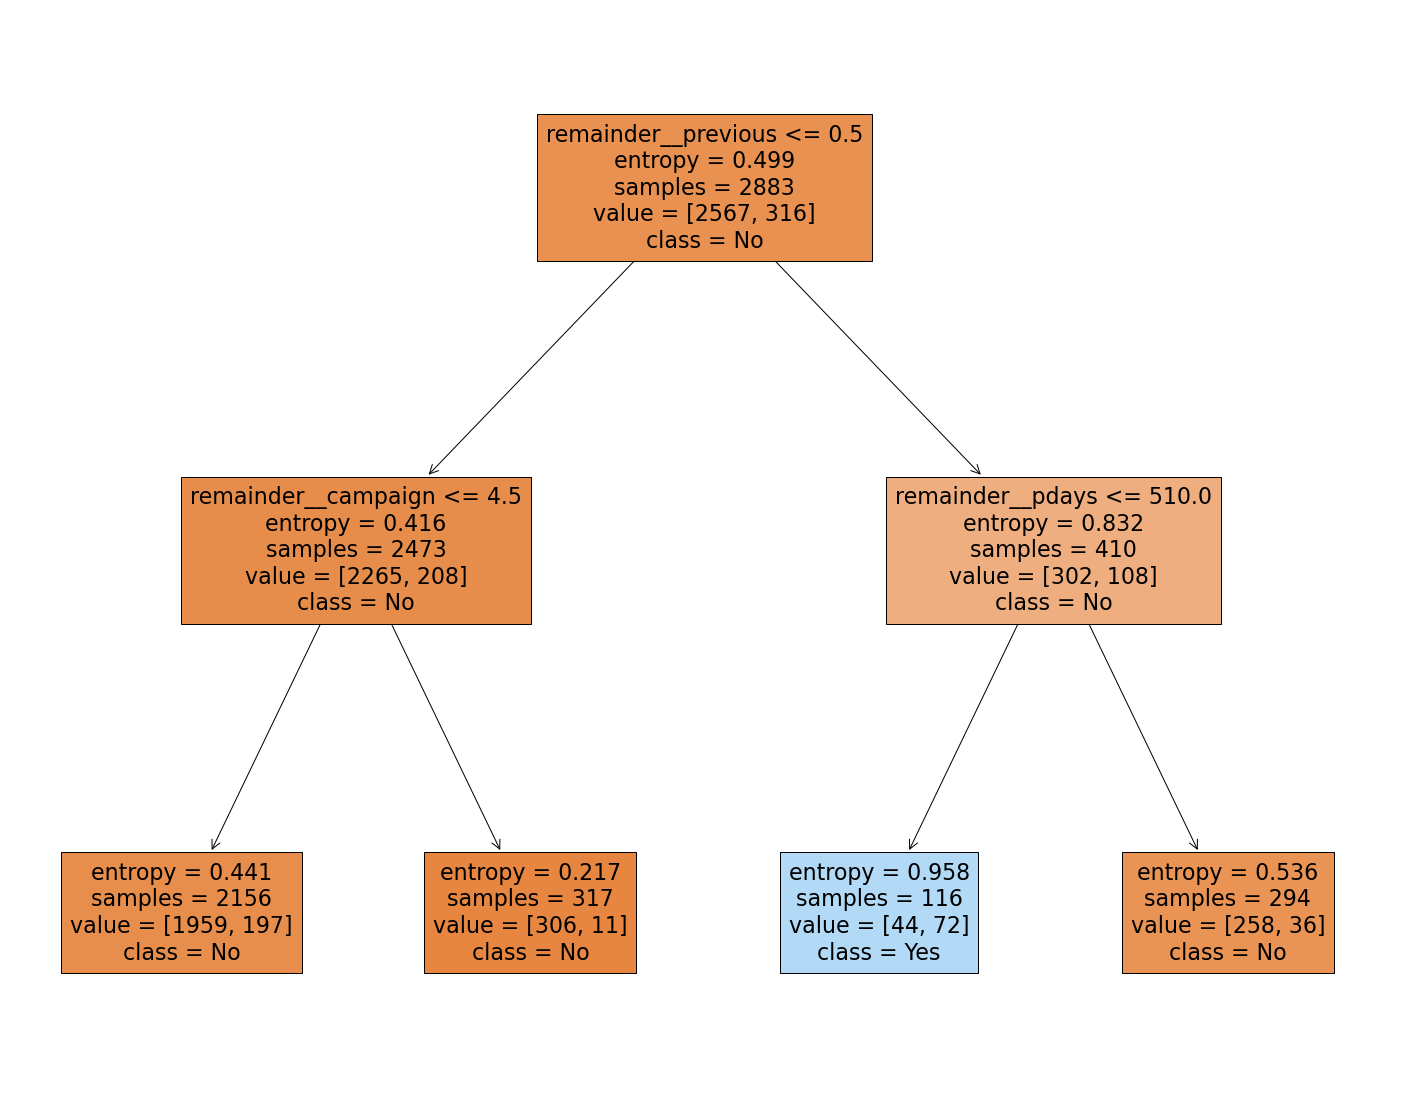

In [14]:
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)
tree_visualizer(tree_tuning.best_estimator_.get_params()['dec_tree'], x_test.columns)

The paper result mentioned that on testing data, they achivieved `90.09%`, `59.06%`, `93.23%` on accuracy score, specificity, and sensitivity respectively. 

As for our result, we achieved `90%` on accuracy score, `64%` on specificity  score and finally `90%` on sensitivity score.

Compared to the paper result, it is concluded that our result is mostly to the paper result. Besides the fact that we are better at specificity score (identifying potential customer).

I would argue that, for this problem, we want to value specificity as there are many customer who do not subscribe and we are interested to know our potential customer.

## Paper 3: https://ieeexplore.ieee.org/document/9649623

This Paper found that using the RandomForest model it had an accuracy of 91.11%.

In [78]:
from sklearn.ensemble import RandomForestClassifier

# Seperate into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, test_size=0.3, random_state=0, stratify=y)


rfc = RandomForestClassifier(random_state=22)

param_grid = {
    'n_estimators': [30, 50, 100],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 8, 12, 16],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [0.1, 0.3, 0.5]
}

tree_tuning = GridSearchCV(
    estimator=rfc, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
tree_tuning.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=22),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 12, 16],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [0.1, 0.3, 0.5],
                         'n_estimators': [30, 50, 100]},
             scoring='accuracy')

In [79]:
print("Best params", tree_tuning.best_params_)

Best params {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.1, 'n_estimators': 30}


              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1101
         1.0       0.70      0.16      0.25       135

    accuracy                           0.90      1236
   macro avg       0.80      0.57      0.60      1236
weighted avg       0.88      0.90      0.87      1236



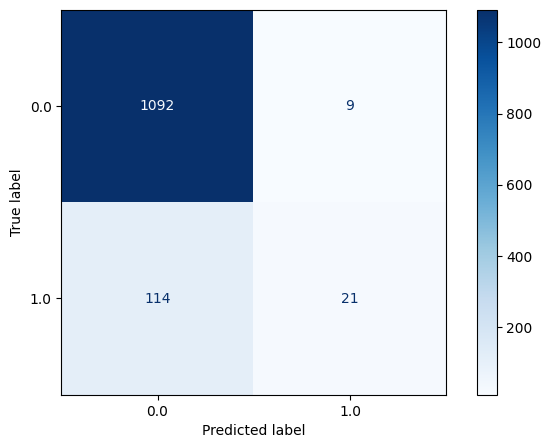

In [80]:
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)

              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88      1101
         1.0       0.30      0.60      0.40       135

    accuracy                           0.81      1236
   macro avg       0.62      0.72      0.64      1236
weighted avg       0.87      0.81      0.83      1236



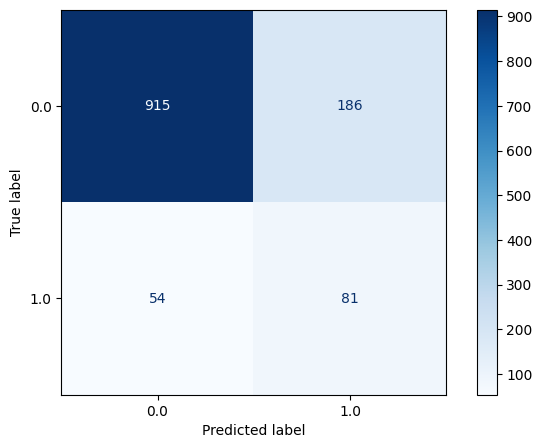

In [81]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier(random_state=22)
tree_tuning = GridSearchCV(
    estimator=brfc, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
tree_tuning.fit(x_train, y_train)
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)

              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1101
         1.0       0.34      0.55      0.42       135

    accuracy                           0.84      1236
   macro avg       0.64      0.71      0.66      1236
weighted avg       0.87      0.84      0.85      1236



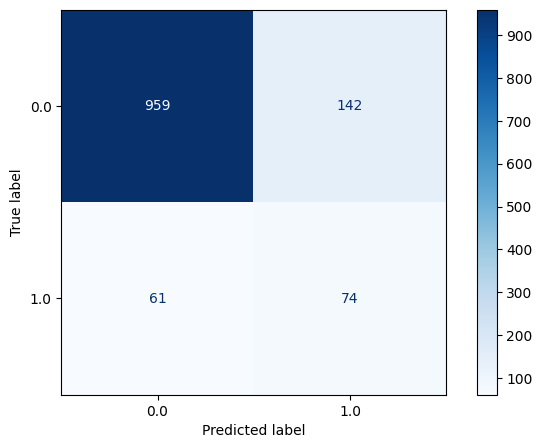

In [82]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

under = RandomUnderSampler(sampling_strategy=1)
pipeline = Pipeline(steps=[('u', under), ('rfc', rfc)])
rfc_param_grid = {
    'rfc__n_estimators': [30, 50, 100],
    'rfc__max_features': ['sqrt', 'log2'],
    'rfc__max_depth': [4, 8, 12, 16],
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__min_samples_split': [0.1, 0.3, 0.5]
}
tree_tuning = GridSearchCV(
    estimator=pipeline, param_grid=rfc_param_grid, scoring="accuracy", cv=10, n_jobs=-1)
tree_tuning.fit(x_train, y_train)
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)

              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91      1101
         1.0       0.38      0.59      0.46       135

    accuracy                           0.85      1236
   macro avg       0.66      0.74      0.69      1236
weighted avg       0.88      0.85      0.86      1236



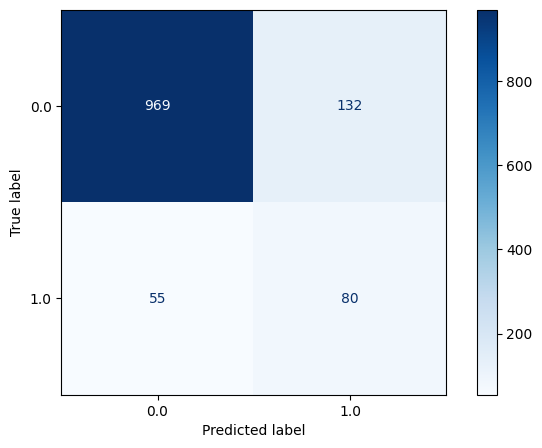

In [83]:
over = RandomOverSampler(sampling_strategy=1)
pipeline = Pipeline(steps=[('o', over), ('rfc', rfc)])
tree_tuning = GridSearchCV(
    estimator=pipeline, param_grid=rfc_param_grid, scoring="accuracy", cv=10, n_jobs=-1)
tree_tuning.fit(x_train, y_train)
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)

## Paper 4:  Bank predictions for prospective long-term deposit investors using machine learning LightGBM and SMOTE

Link: https://ieeexplore.ieee.org/document/9397083

This Paper got the best result by using LightGBM Classifier with an accuracy of `91.63%`.

In [15]:
# # import lightgbm module (lightgbm==3.3.3)
# %pip install lightgbm
# # import imblearn module (imblearn==0.9.1)
# %pip install imblearn

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def report_result(y_pred, y_true, clf):
    cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    print(classification_report(y_true, y_pred,digits=4))
    print("Accuracy : ",accuracy_score(y_pred, y_true))
    print("Precison : ",precision_score(y_pred, y_true, average = 'weighted'))
    print("Recall : ",recall_score(y_pred, y_true, average = 'weighted'))
    print("F1 : ",f1_score(y_pred, y_true, average = 'weighted'))

In [17]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

# The following features are not used by the paper, therefore, we're not going to use these features as well
LGBM_dataset_x = x.drop(columns=["remainder__euribor3m", "remainder__nr.employed",
                    "remainder__cons.price.idx", "remainder__emp.var.rate", "remainder__cons.conf.idx"], inplace=False)

# Seperate into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    LGBM_dataset_x, y, train_size=0.7, test_size=0.3, random_state=42, stratify=y)

In [18]:
LGBM = LGBMClassifier(random_state=10)

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [5,7,9],
    'n_estimators': [100,150,200],
    'min_child_samples': [50,100,150]
}

pipe = Pipeline(steps=[
    ('LGBM', LGBM)])

tree_tuning = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=10)
tree_tuning.fit(x_train, y_train)
print("Best params", tree_tuning.best_params_)

Best params {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 150, 'n_estimators': 150}


LGBMClassifier
              precision    recall  f1-score   support

         0.0     0.9077    0.9909    0.9475      1101
         1.0     0.7059    0.1778    0.2840       135

    accuracy                         0.9021      1236
   macro avg     0.8068    0.5843    0.6157      1236
weighted avg     0.8856    0.9021    0.8750      1236

Accuracy :  0.9021035598705501
Precison :  0.9685494308890514
Recall :  0.9021035598705501
F1 :  0.9292099728164386


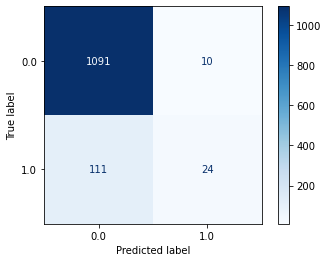

In [19]:
print('LGBMClassifier')
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)

In [20]:
from imblearn.over_sampling import SMOTE

print("Before SMOTE, counts of label '1': {}".format(sum(y_train == 1)))
print("Before SMOTE, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 10)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
  
print('After SMOTE, the shape of train_X: {}'.format(x_train_res.shape))
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After SMOTE, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_res == 0)))

Before SMOTE, counts of label '1': 316
Before SMOTE, counts of label '0': 2567 

After SMOTE, the shape of train_X: (5134, 46)
After SMOTE, the shape of train_y: (5134,) 

After SMOTE, counts of label '1': 2567
After SMOTE, counts of label '0': 2567


In [21]:
LGBM = LGBMClassifier(random_state=10)

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [5,7,9],
    'n_estimators': [100,150,200],
    'min_child_samples': [50,100,150]
}

pipe = Pipeline(steps=[
    ('LGBM', LGBM)])

tree_tuning = GridSearchCV(estimator=LGBM, param_grid=param_grid, cv=10) #scoring="depth", 
tree_tuning.fit(x_train_res, y_train_res)
print("Best params", tree_tuning.best_params_)

Best params {'boosting_type': 'dart', 'max_depth': 7, 'min_child_samples': 50, 'n_estimators': 200}


LGBMClassifier with SMOTE
              precision    recall  f1-score   support

         0.0     0.9101    0.9837    0.9454      1101
         1.0     0.6087    0.2074    0.3094       135

    accuracy                         0.8989      1236
   macro avg     0.7594    0.5955    0.6274      1236
weighted avg     0.8772    0.8989    0.8760      1236

Accuracy :  0.8988673139158576
Precison :  0.9547618930977396
Recall :  0.8988673139158576
F1 :  0.9217670430019778


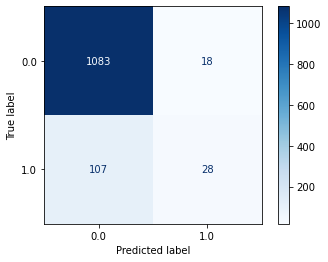

In [22]:
print('LGBMClassifier with SMOTE')
report_result(tree_tuning.predict(x_test), y_test, tree_tuning)

By just using LightGBM Classifier we achivieved `90.21%`, `96.85%`, `90.21%` and `92.92%`  on Accuracy, Precison, Recall and F1 F1-score. 

By using LightGBM Classifier and SMOTE we achivieved `90.21%`, `96.85%`, `90.21%` and `92.92%`  on Accuracy, Precison, Recall and F1 F1-score. 